In [1]:
import numpy as np
import pandas as pd
import os

from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

from tqdm import notebook

import re
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/enron-email-intent/intent_neg.txt
/kaggle/input/enron-email-intent/intent_pos.txt


In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ 

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
neg_intent_lines = []
pos_intent_lines = []

with open('/kaggle/input/enron-email-intent/intent_neg.txt') as f:
    neg_intent_lines = f.readlines()
    
with open('/kaggle/input/enron-email-intent/intent_pos.txt') as f:
    pos_intent_lines = f.readlines()

In [4]:
neg_intent_lines[:5]

['## Please do not write below this line ##\n',
 '&quot;I would like to thank both agents Charles and Conroy for their help and patience.\n',
 '&quot;The guy that assisted me with my booking was awesome.\n',
 '* If you delete a photo by accident, you can restore it from the SnapSync website.\n',
 '* If you edit the map, when you return to Files view you can either discard your changes, or save it as a new map\n']

In [5]:
pos_intent_lines[:5]

['A dinner / lunch on Fri would work for me.\n',
 'A meeting has been scheduled on 3/16 with the California Fish and Game to discuss the following issues\n',
 'A meeting is being scheduled so we can discuss these matters further.\n',
 'A reminder: 900am Monday, my office.\n',
 'Actually, you could set the priorities for us.\n']

In [6]:
len(neg_intent_lines), len(pos_intent_lines)

(2403, 1252)

In [7]:
def build_df(lines, intent):
    df = pd.DataFrame(lines)
    df.columns = ['text']
    df['intent'] = intent
    return df

In [8]:
neg_df = build_df(neg_intent_lines, 0)
neg_df.head()

,text,intent
0,## Please do not write below this line ##\n,0
1,&quot;I would like to thank both agents Charle...,0
2,&quot;The guy that assisted me with my booking...,0
3,"* If you delete a photo by accident, you can r...",0
4,"* If you edit the map, when you return to File...",0


In [9]:
pos_df = build_df(pos_intent_lines, 1)
pos_df.head()

,text,intent
0,A dinner / lunch on Fri would work for me.\n,1
1,A meeting has been scheduled on 3/16 with the ...,1
2,A meeting is being scheduled so we can discuss...,1
3,"A reminder: 900am Monday, my office.\n",1
4,"Actually, you could set the priorities for us.\n",1


In [10]:
df = pd.concat([neg_df, pos_df])
df.head()

,text,intent
0,## Please do not write below this line ##\n,0
1,&quot;I would like to thank both agents Charle...,0
2,&quot;The guy that assisted me with my booking...,0
3,"* If you delete a photo by accident, you can r...",0
4,"* If you edit the map, when you return to File...",0


In [11]:
df = df.sample(frac=1)
df = df.reset_index()
df = df.drop(['index'], axis=1).dropna()
df.head()

,text,intent
0,"In honor of Mother's Day, take advantage of th...",0
1,"By the way, I was talking to my friend and col...",0
2,Will you send a note to folks regarding the GA...,1
3,"Roger, if EPA has approved other alternate met...",1
4,Please delete all the files from your hard dri...,1


In [12]:
device = 'cuda'
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [13]:
x_train, x_temp, y_train, y_temp = train_test_split(df['text'], df['intent'], random_state=97,test_size=0.3, stratify=df['intent'])
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, random_state=97,test_size=0.5)
len(x_train),len(x_val), len(x_test)

(2558, 548, 549)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='intent', ylabel='count'>

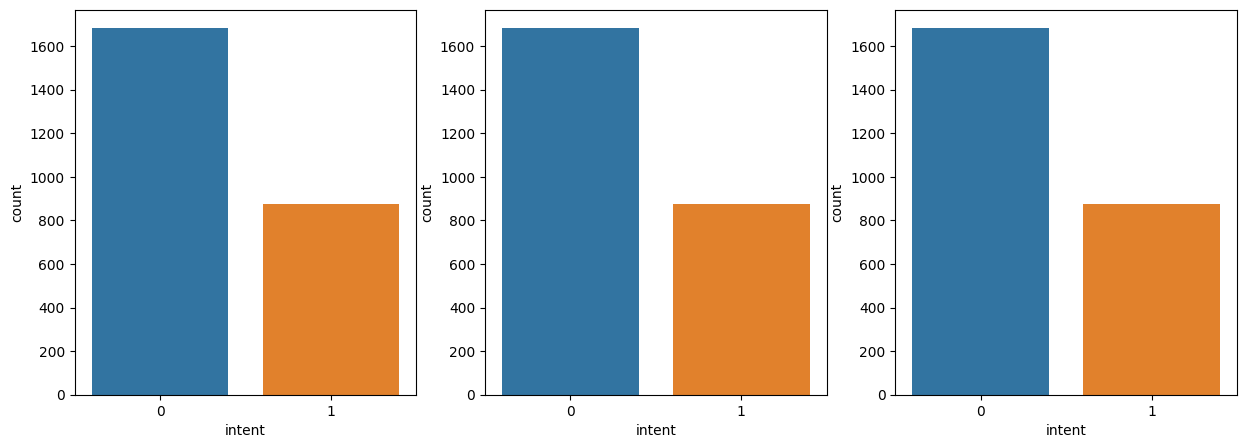

In [15]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x=y_train, ax=axes[0])
sns.countplot(x=y_train, ax=axes[1])
sns.countplot(x=y_train, ax=axes[2])

In [16]:
x_train.astype(str).to_list()[:5]

["If you've ever thought about pursuing Criminal Justice, now is a great time to act.\n",
 'Bob, there also are legal issues to address, so I appreciate your keeping me in the loop as this evolves.\n',
 'As you have correctly pointed out, the model validation issues cannot be handled internally by Research.\n',
 'Can you prepare a brief presentation that would serve as a discussion document for such a meeting.\n',
 "Also, looks like we're on for Portland next Tuesday/Wednesday.\n"]

In [17]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

In [18]:
df['text'].apply(lambda x: len(x.split(' '))).max()

222

In [19]:
MAX_LEN = 256

In [20]:
def tokenize(data):
    # `encode_plus` will:
    #    (1) Tokenize the sentence
    #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
    #    (3) Truncate/Pad sentence to max length
    #    (4) Map tokens to their IDs
    #    (5) Create attention mask
    #    (6) Return a dictionary of outputs
    encodings = tokenizer.batch_encode_plus(
        data,
        truncation=True,
        add_special_tokens=True, # Add `[CLS]` and `[SEP]`
        max_length=MAX_LEN,                  # Max length to truncate/pad
        padding='max_length',         # Pad sentence to max length
        return_tensors='pt',           # Return PyTorch tensor
        return_attention_mask=True      # Return attention mask
    )
    return encodings['input_ids'], encodings['attention_mask']

In [21]:
train_ids, train_attn_mask = tokenize(x_train.astype(str).to_list())
val_ids, val_attn_mask = tokenize(x_val.astype(str).to_list())
train_ids.shape, val_ids.shape

(torch.Size([2558, 256]), torch.Size([548, 256]))

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import time

In [23]:
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)
train_labels[:5], val_labels[:5]

(tensor([0, 1, 0, 1, 1]), tensor([1, 0, 0, 0, 0]))

In [24]:
BATCH_SIZE = 16

In [25]:
train_data = TensorDataset(train_ids, train_attn_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_ids, val_attn_mask, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

In [26]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False, dropout=0.5):
        super(BertClassifier, self).__init__()
        bert_emb_size, hidden_size, num_classes = 768, 128, 2

        self.bert = AutoModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(bert_emb_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [27]:
def initialize_model(epochs=5):
    model = BertClassifier(freeze_bert=False, dropout=0.2)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0, 
        num_training_steps=total_steps
    )
    return model, optimizer, scheduler

In [28]:
def set_seed(seed_value=97):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [29]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    print("Start training...\n")
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [30]:
def evaluate(model, loss_fn, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [31]:
# EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
# set_seed(97)
# model, optimizer, scheduler = initialize_model(epochs=EPOCHS)
# train(model, loss_fn, train_dataloader, val_dataloader, epochs=EPOCHS, evaluation=True)

In [32]:
import torch.nn.functional as F

In [33]:
def predict(model, dataloader):
    model.eval()
    all_logits = []
    for batch in dataloader:
        input_ids, attn_mask = tuple(t.to(device) for t in batch)[:2]
        
        with torch.no_grad():
            logits = model(input_ids, attn_mask)
        all_logits.append(logits)
        
    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    return probs

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
# probs = predict(model, val_dataloader)
# y_pred = np.where(probs[:, 1] >= 0.5, 1, 0)
# accuracy_score(y_pred, y_val)

Reducing the epoch number as i see overfitting

In [36]:
cmb_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
cmb_train_sampler = RandomSampler(cmb_train_data)
cmb_train_dataloader = DataLoader(cmb_train_data, sampler=cmb_train_sampler, batch_size=BATCH_SIZE)

set_seed(97)
model, optimizer, scheduler = initialize_model(epochs=5)
train(model, loss_fn, cmb_train_dataloader, epochs=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in 

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.592730   |     -      |     -     |   9.63   
   1    |   40    |   0.436144   |     -      |     -     |   7.75   
   1    |   60    |   0.473786   |     -      |     -     |   7.75   
   1    |   80    |   0.400300   |     -      |     -     |   7.74   
   1    |   100   |   0.383576   |     -      |     -     |   7.76   
   1    |   120   |   0.322935   |     -      |     -     |   7.73   
   1    |   140   |   0.321139   |     -      |     -     |   7.75   
   1    |   160   |   0.296482   |     -      |     -     |   7.76   
   1    |   180   |   0.356192   |     -      |     -     |   7.73   
   1    |   194   |   0.385220   |     -      |     -     |   5.11   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapse

In [37]:
test_ids, test_attn_mask = tokenize(x_test.astype(str).to_list())

test_dataset = TensorDataset(test_ids, test_attn_mask)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [38]:
probs = predict(model, test_dataloader)

threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

print("Number of texts with request to action intent: ", preds.sum())

Number of texts with request to action intent:  202


<AxesSubplot: xlabel='intent', ylabel='count'>

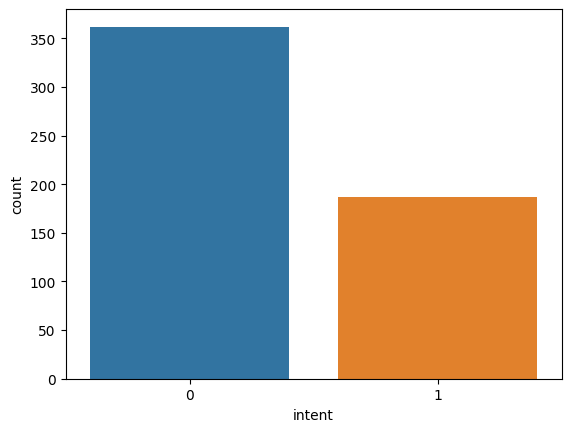

In [39]:
sns.countplot(x=y_test)

In [40]:
y_test.sum()

187

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
confusion_matrix(y_test, preds)

array([[327,  35],
       [ 20, 167]])

In [43]:
accuracy_score(y_test, preds)

0.8998178506375227

In [44]:
output = x_test[preds==1]
list(output.sample(20))

['I think you should have this conversation with the senior person and I will work on it at the board level.\n',
 'We shall try to arrange a video conference with Houston when Howard is back.\n',
 'I would appreciate the opportunity to discuss it with you to get your input, etc.\n',
 'Is there an agenda for the meeting on the 5th?\n',
 "I'm very much looking forward to meeting you, and hope that you can visit the office while your hear to discuss California.\n",
 'Jim, can you send me hard copies - I am having trouble opening these reports.\n',
 'Please, call me at 713 853 3848 on Thursday or Friday.\n',
 "If not, do you want to meet this weekend for a wee bit to discuss? i'm in town.\n",
 'I would like to discuss the entire process chain as part of the timelines, personnel responsibilities and key action items.\n',
 'If not by e-mail, is it something that can be faxed?\n',
 'Also, please come join us Thursday, March 22 for a webinar hosted by John Boyer - the creator of Skedi.\n',
 'P

In [45]:
output = x_test[(preds==0) & (y_test==1)]
list(output.sample(20))

["Probably wouldn't hurt to log the same call or e:mail in to the rest of the guys on the list.\n",
 'Feel free to move forward with whatever you need to do.\n',
 'Looks good to me--I think you ought to have them file it asap.\n',
 'Please do NOT assume that the IP-address is the same as it was when your were connection the last time.\n',
 "Don't make any changes for now.\n",
 'I shall be glad to meet you and help you with the project.\n',
 'It is ok to provide the requested information.\n',
 "We'll see you tomorrow.\n",
 "If you'd like to discuss, feel free to give me a call at 415.782.7822.\n",
 "Keep these names, and I'll keep you posted on who to schedule with him.\n",
 "I am not worried about the timing on that, so don't start this until you feel that it makes sense for you and your family.\n",
 'If you consider you have the inquired skills and would like to be approved for this job or would like to discuss it, please reply to this email and indicate your interest.\n',
 "If you're

In [46]:
len(output)

20

In [47]:
def get_prediction_for_email(text):
    test_sent = [text]
    test_sent_id, test_sent_attn_mask = tokenize(test_sent)

    test_sent_dataset = TensorDataset(test_sent_id, test_sent_attn_mask)
    test_sent_sampler = SequentialSampler(test_sent_dataset)
    test_sent_dataloader = DataLoader(test_sent_dataset, sampler=test_sent_sampler, batch_size=BATCH_SIZE)
    
    prob = predict(model, test_sent_dataloader)
    threshold = 0.9
    pred = np.where(prob[:, 1] > threshold, 1, 0)
    return prob, pred

In [48]:
get_prediction_for_email('please upload a revised financial statement via this form')

(array([[0.00455703, 0.995443  ]], dtype=float32), array([1]))